In [15]:
import math
import numpy as np
from itertools import product
from scipy.stats import beta
from scipy.optimize import linprog

In [16]:
class MultiProductEnvironment:
    def __init__(self, k, T, a_vec, b_vec):
        """
        :param k: Number of product streams
        :param T: Time horizon
        :param a_vec: List or array of length k, alpha (a) parameters for each product's Beta distribution
        :param b_vec: List or array of length k, beta (b) parameters for each product's Beta distribution
        """
        self.k = k
        self.T = T
        self.a = np.array(a_vec)
        self.b = np.array(b_vec)

        if len(self.a) != k or len(self.b) != k:
            raise ValueError("Length of a_vec and b_vec must match k.")

        self.current_round = 0

    def reset(self):
        self.current_round = 0

    def play_round(self):
        """
        Returns a valuation vector: one sampled Beta value for each product stream.
        """
        if self.current_round >= self.T:
            raise StopIteration("Time horizon exceeded.")
        
        self.current_round += 1
        valuations = beta.rvs(self.a, self.b)
        return valuations


In [17]:
class MultiProductBudgetedOracleAgent:
    def __init__(self, arm_values_per_product, a_params, b_params, T, B):
        """
        arm_values_per_product: List of lists, each sublist contains arm values (prices) for one product.
        a_params, b_params: Lists of Beta distribution parameters for each product.
        T: Time horizon
        B: Total budget
        """
        self.arm_values_per_product = arm_values_per_product
        self.a_params = a_params
        self.b_params = b_params
        self.k = len(arm_values_per_product)   # number of products
        self.T = T
        self.B = B
        self.remaining_budget = B
        self.round = 0

        # Compute expected reward and success probabilities for each arm
        self.expected_rewards_per_product = []
        self.success_probs_per_product = []

        for product_idx in range(self.k):
            a, b = a_params[product_idx], b_params[product_idx]
            values = arm_values_per_product[product_idx]
            success_probs = [1 - beta.cdf(v, a, b) for v in values]
            expected_rewards = [p * v for p, v in zip(success_probs, values)]

            self.success_probs_per_product.append(success_probs)
            self.expected_rewards_per_product.append(expected_rewards)

        # Generate all possible superarms (power set excluding combinations with more than one arm per product)
        self.superarms = self._generate_superarms()

    def _generate_superarms(self):
        """
        Each element is a tuple of indices (or None) of selected arms per product.
        For example, (0, None, 2) means: play arm 0 for product 0, skip product 1, play arm 2 for product 2.
        """
        options_per_product = [
            [None] + list(range(len(arms)))
            for arms in self.arm_values_per_product
        ]
        return list(product(*options_per_product))

    def choose_superarm(self):
        if self.round >= self.T or self.remaining_budget <= 0:
            return None

        rounds_remaining = self.T - self.round
        rho = self.remaining_budget / rounds_remaining  # max expected budget per round

        num_superarms = len(self.superarms)
        expected_rewards = []
        expected_costs = []

        for sa in self.superarms:
            total_reward = 0
            total_cost = 0
            for prod_idx, arm_idx in enumerate(sa):
                if arm_idx is not None:
                    total_reward += self.expected_rewards_per_product[prod_idx][arm_idx]
                    total_cost += self.success_probs_per_product[prod_idx][arm_idx]
            expected_rewards.append(total_reward)
            expected_costs.append(total_cost)

        # LP: maximize sum x_i * reward_i  subject to sum x_i * cost_i <= rho, sum x_i = 1, 0 <= x_i <= 1
        c = -np.array(expected_rewards)
        A = [expected_costs]
        b = [rho]
        A_eq = [np.ones(num_superarms)]
        b_eq = [1]
        bounds = [(0, 1) for _ in range(num_superarms)]

        res = linprog(c, A_ub=A, b_ub=b, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method="highs")

        if not res.success:
            # fallback: choose no products
            return tuple([None] * self.k)

        x = res.x
        index = np.random.choice(num_superarms, p=x)
        chosen_superarm = self.superarms[index]
        return chosen_superarm

    def update(self, chosen_superarm, valuation_vector):
        """
        chosen_superarm: tuple of selected arm indices (or None) per product
        valuation_vector: sampled valuations from environment
        """
        sales_this_round = 0
        reward = 0

        for prod_idx, arm_idx in enumerate(chosen_superarm):
            if arm_idx is None:
                continue
            price = self.arm_values_per_product[prod_idx][arm_idx]
            if valuation_vector[prod_idx] >= price:
                sales_this_round += 1
                reward += price

        self.remaining_budget -= sales_this_round
        self.round += 1
        return reward, sales_this_round

In [18]:
class MultiProductBudgetedUCBAgent:
    def __init__(self, arm_values_per_product, T, B):
        self.arm_values_per_product = arm_values_per_product
        self.T = T
        self.B = B
        self.k = len(arm_values_per_product)
        self.n_arms = len(arm_values_per_product[0])  # assuming all have same length
        self.remaining_budget = B
        self.round = 0

        # Superarms: same as in oracle
        self.superarms = self._generate_superarms()

        # Track stats: plays, successes, rewards
        self.arm_play_count = np.zeros((self.k, self.n_arms))
        self.arm_success_count = np.zeros((self.k, self.n_arms))
        self.arm_reward_sum = np.zeros((self.k, self.n_arms))

    def _generate_superarms(self):
        options_per_product = [
            [None] + list(range(len(arms)))
            for arms in self.arm_values_per_product
        ]
        return list(product(*options_per_product))

    def choose_superarm(self):
        if self.round >= self.T or self.remaining_budget <= 0:
            return None

        # Initialization phase: play each index once (across all streams)
        if self.round < self.n_arms:
            return tuple(
                i if i < len(self.arm_values_per_product[p]) else None
                for p, i in enumerate([self.round] * self.k)
            )

        # --- UCB Reward / LCB Cost Estimation ---
        ucb_rewards = [[0] * self.n_arms for _ in range(self.k)]
        lcb_costs = [[0] * self.n_arms for _ in range(self.k)]

        for p in range(self.k):
            for a in range(self.n_arms):
                n = self.arm_play_count[p][a]
                if n == 0:
                    ucb_rewards[p][a] = float("inf")
                    lcb_costs[p][a] = 0
                    continue
                avg_reward = self.arm_reward_sum[p][a] / n
                success_prob = self.arm_success_count[p][a] / n

                # Use Hoeffding-type bounds
                delta = 1 / self.T
                bonus = math.sqrt(2 * math.log(1 / delta) / n)

                ucb_rewards[p][a] = min(1.0, avg_reward + bonus)
                lcb_costs[p][a] = max(0.0, success_prob - bonus)

        # --- Solve LP with UCB and LCB estimates ---
        rounds_remaining = self.T - self.round
        rho = self.remaining_budget / rounds_remaining
        num_superarms = len(self.superarms)
        expected_rewards = []
        expected_costs = []

        for sa in self.superarms:
            total_reward = 0
            total_cost = 0
            for p, a in enumerate(sa):
                if a is not None:
                    total_reward += ucb_rewards[p][a]
                    total_cost += lcb_costs[p][a]
            expected_rewards.append(total_reward)
            expected_costs.append(total_cost)

        # LP: maximize expected reward under expected cost constraint
        c = -np.array(expected_rewards)
        A = [expected_costs]
        b = [rho]
        A_eq = [np.ones(num_superarms)]
        b_eq = [1]
        bounds = [(0, 1) for _ in range(num_superarms)]

        res = linprog(c, A_ub=A, b_ub=b, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method="highs")

        if not res.success:
            return tuple([None] * self.k)

        x = res.x
        index = np.random.choice(num_superarms, p=x)
        return self.superarms[index]

    def update(self, chosen_superarm, valuation_vector):
        sales_this_round = 0
        reward = 0

        for p, a in enumerate(chosen_superarm):
            if a is None:
                continue

            price = self.arm_values_per_product[p][a]
            self.arm_play_count[p][a] += 1

            if valuation_vector[p] >= price:
                self.arm_success_count[p][a] += 1
                self.arm_reward_sum[p][a] += price
                reward += price
                sales_this_round += 1

        self.remaining_budget -= sales_this_round
        self.round += 1
        return reward, sales_this_round


In [19]:
import numpy as np

class MultiProductPrimalDualAgent:
    """
    Multi-product primal–dual agent with decomposed primal regret minimizers.

    - Primal: one EXP3.P bandit per product (learns pricing *within* the product).
    - Dual: a single λ pacing the *total* budget across products.
    - Gating: per-round fractional-knapsack using current success-rate estimates to
      select which products to activate so that expected spend <= ρ.

    Reward model (same sale-centric logic as your univariate agent):
      If a product m is activated and sells at price p:
         bandit reward for product m = max(p - λ, 0)
      else: 0
      Budget cost = number of successful sales in the round.

    Parameters
    ----------
    arm_values_per_product : list[list[float]]
        Prices (arms) per product. Assumes same #arms for all products.
    T : int
        Horizon.
    B : int
        Total budget.
    eta, gamma, alpha : float | None
        EXP3.P parameters; if None, set to canonical values.
    dual_lr : float | None
        Dual stepsize; defaults to eta.
    eta_mult : float
        Multiplier on eta for faster adaptation.
    forget_beta : float in [0,1)
        Exponential forgetting for non-stationarity (0 disables).
    dynamic_rho : bool
        If True, uses rho_t = remaining_budget / (T - t) for gating & dual cap;
        if False (default), uses constant rho = B/T (matches your univariate agent).
    rng : int | np.random.Generator | None
        Seed or generator.
    """

    def __init__(self, arm_values_per_product, T, B,
                 eta=None, gamma=None, alpha=None, dual_lr=None,
                 eta_mult=1.0, forget_beta=0.0,
                 dynamic_rho=False, rng=None):

        self.prices = [np.asarray(v, dtype=float) for v in arm_values_per_product]
        self.k = len(self.prices)                 # number of products
        assert self.k >= 1
        self.n_arms = len(self.prices[0])         # same for all products (per your note)
        for m in range(self.k):
            assert len(self.prices[m]) == self.n_arms

        self.T = int(T)
        self.B0 = int(B)
        self.dynamic_rho = bool(dynamic_rho)

        # Base pacing rate and cap
        self.rho_const = self.B0 / float(self.T)
        self.lambda_cap_const = 1.0 / max(self.rho_const, 1e-12)

        # EXP3.P canonical params
        K = self.n_arms
        if gamma is None:
            gamma = min(0.4, np.sqrt(K * np.log(max(2, K)) / max(1, self.T)))
        if eta is None:
            eta = gamma / (3.0 * max(1, K))
        if alpha is None:
            alpha = gamma / (3.0 * max(1, K))
        if dual_lr is None:
            dual_lr = eta

        self.gamma = float(gamma)
        self.eta = float(eta) * float(eta_mult)
        self.alpha = float(alpha)
        self.dual_lr = float(dual_lr)
        self.forget_beta = float(forget_beta)

        # Per-product EXP3.P state
        self.weights = np.ones((self.k, self.n_arms), dtype=float)
        self.last_probs = np.full((self.k, self.n_arms), 1.0 / self.n_arms, dtype=float)
        self.last_arm = np.full(self.k, -1, dtype=int)

        # Success-rate estimates (Laplace smoothing) for gating
        self.play_count = np.zeros((self.k, self.n_arms), dtype=float)
        self.success_count = np.zeros((self.k, self.n_arms), dtype=float)

        # Global state
        self.lmbda = 0.0
        self.t = 0
        self.remaining_budget = int(B)
        self.total_reward = 0.0

        self.rng = np.random.default_rng(rng)

    # ---------- helpers ----------
    def _probs(self, m):
        w = self.weights[m]
        s = w.sum()
        if not np.isfinite(s) or s <= 0:
            w = np.ones_like(w); s = w.sum()
        p = (1.0 - self.gamma) * (w / s) + self.gamma / self.n_arms
        p = np.clip(p, 1e-12, 1.0)
        p /= p.sum()
        return p

    def _rho_and_cap(self):
        if not self.dynamic_rho:
            return self.rho_const, self.lambda_cap_const
        rounds_left = max(1, self.T - self.t)
        rho_t = self.remaining_budget / float(rounds_left)
        return rho_t, 1.0 / max(rho_t, 1e-12)

    def _success_estimate(self, m, a):
        # Laplace-smoothed estimate to avoid zeros in early rounds
        s = self.success_count[m, a]
        n = self.play_count[m, a]
        return (s + 1.0) / (n + 2.0)

    def _fractional_knapsack(self, rewards, costs, capacity):
        """
        Given vectors rewards (r_m) and costs (c_m >= 0) and capacity 'capacity',
        return x in [0,1]^k maximizing sum x_m r_m s.t. sum x_m c_m <= capacity.
        Greedy solution. Returns fractional x.
        """
        k = len(rewards)
        idx = np.arange(k)
        costs = np.asarray(costs, dtype=float)
        rewards = np.asarray(rewards, dtype=float)

        # Guard: nothing to allocate or zero capacity
        if capacity <= 0 or np.all(costs <= 0):
            return np.zeros(k, dtype=float)

        ratio = np.zeros(k, dtype=float)
        for i in range(k):
            c = max(costs[i], 1e-12)
            ratio[i] = rewards[i] / c

        order = np.argsort(-ratio)  # descending by value density
        x = np.zeros(k, dtype=float)
        budget = 0.0
        for i in order:
            if costs[i] <= 0:
                continue
            if budget + costs[i] <= capacity:
                x[i] = 1.0
                budget += costs[i]
            else:
                x[i] = max(0.0, (capacity - budget) / costs[i])
                break
        return x

    # ---------- public API ----------
    def choose_superarm(self):
        # Halt if out of time or budget
        if self.t >= self.T or self.remaining_budget <= 0:
            return None

        rho, _ = self._rho_and_cap()

        # 1) Each product samples a price from its own bandit
        chosen_arms = []
        prices = []
        probs = []
        for m in range(self.k):
            p = self._probs(m)
            a = int(self.rng.choice(self.n_arms, p=p))
            self.last_probs[m] = p
            self.last_arm[m] = a
            chosen_arms.append(a)
            prices.append(self.prices[m][a])
            probs.append(p)

        chosen_arms = np.asarray(chosen_arms, dtype=int)
        prices = np.asarray(prices, dtype=float)

        # 2) Build gating problem from current estimates:
        #    c_m = estimated success prob at (m, a_m)
        #    r_m = c_m * max(price - λ, 0)
        c_hat = np.zeros(self.k, dtype=float)
        r_hat = np.zeros(self.k, dtype=float)
        for m in range(self.k):
            a = chosen_arms[m]
            c_hat[m] = self._success_estimate(m, a)
            r_hat[m] = c_hat[m] * max(prices[m] - self.lmbda, 0.0)

        # 3) Fractional knapsack to get activation fractions x in [0,1]^k
        x_frac = self._fractional_knapsack(r_hat, c_hat, rho)

        # 4) Sample activation according to x_frac (deterministic for x=1; Bernoulli for 0<x<1)
        active = np.zeros(self.k, dtype=bool)
        for m in range(self.k):
            if x_frac[m] >= 1.0 - 1e-12:
                active[m] = True
            elif x_frac[m] <= 1e-12:
                active[m] = False
            else:
                active[m] = (self.rng.random() < x_frac[m])

        # 5) Return superarm: selected index if active; otherwise None
        superarm = tuple(int(chosen_arms[m]) if active[m] else None for m in range(self.k))
        return superarm

    def update(self, chosen_superarm, valuation_vector):
        """
        chosen_superarm : tuple[int|None, ...] as returned by choose_superarm()
        valuation_vector : np.ndarray shape (k,) with valuations in (0,1)
        """
        if chosen_superarm is None:
            return 0.0, 0

        sales_this_round = 0
        round_reward = 0.0

        # For dual update after loop
        for m, a in enumerate(chosen_superarm):
            if a is None:
                continue

            price = float(self.prices[m][a])
            # Book-keeping for success estimates
            self.play_count[m, a] += 1.0

            sale = (valuation_vector[m] >= price)
            if sale:
                self.success_count[m, a] += 1.0
                bandit_reward = max(price - self.lmbda, 0.0)
                round_reward += price
                sales_this_round += 1
            else:
                bandit_reward = 0.0

            # EXP3.P update for product m
            p = float(self.last_probs[m, a])
            xhat = np.zeros(self.n_arms, dtype=float)
            xhat[a] = bandit_reward / max(p, 1e-12)

            bias = self.alpha / (np.maximum(self.last_probs[m], 1e-12) * np.sqrt(self.n_arms * self.T))
            self.weights[m] *= np.exp(self.eta * (xhat + bias))

            if self.forget_beta > 0.0:
                self.weights[m] = self.weights[m] ** (1.0 - self.forget_beta)

        # Dual update (global pacing)
        rho, lambda_cap = self._rho_and_cap()
        self.lmbda = float(np.clip(self.lmbda - self.dual_lr * (rho - sales_this_round),
                                   0.0, lambda_cap))

        # Budget & time
        self.remaining_budget = max(0, self.remaining_budget - sales_this_round)
        self.total_reward += round_reward
        self.t += 1

        return round_reward, sales_this_round

    # ---------- inspectors ----------
    def current_probs(self, product_index):
        """Return current price distribution for a given product."""
        return self._probs(int(product_index)).copy()

    def state(self):
        return {
            "t": self.t,
            "remaining_budget": self.remaining_budget,
            "lambda": self.lmbda,
            "rho_const": self.rho_const,
            "dynamic_rho": self.dynamic_rho,
            "weights": self.weights.copy(),
            "total_reward": self.total_reward,
        }


In [20]:
import numpy as np
import math
import matplotlib.pyplot as plt

# If not already imported elsewhere:
from itertools import product
from scipy.stats import beta
from scipy.optimize import linprog

def _generate_valuation_path(env, seed=None):
    """
    Draw a single valuation path of shape (T, k) from the given environment class/instance.
    The env you provided is stateful; we'll instantiate a fresh one to ensure reproducibility.
    """
    rng = np.random.default_rng(seed)
    # Rebuild env to reset any internal RNG (the Beta draws use scipy which is fine)
    k, T, a_vec, b_vec = env.k, env.T, env.a.copy(), env.b.copy()
    env2 = MultiProductEnvironment(k=k, T=T, a_vec=a_vec, b_vec=b_vec)
    valuations = []
    for _ in range(T):
        v = env2.play_round()
        valuations.append(np.asarray(v, dtype=float))
    return np.vstack(valuations)  # (T, k)

def _simulate_agent_on_path(valuations_Tk, agent):
    """
    Feed the same valuation path to an agent. Returns per-round reward vector (len T),
    remaining-budget trace (len T), and the depletion round (int or None).
    """
    T, k = valuations_Tk.shape
    rewards = np.zeros(T, dtype=float)
    budgets = np.zeros(T, dtype=int)
    depletion_round = None

    for t in range(T):
        # Agent decides what to play this round
        chosen = agent.choose_superarm()
        if chosen is None:
            # either horizon reached internally or budget exhausted
            budgets[t] = getattr(agent, "remaining_budget", 0)
            continue

        r, sold = agent.update(chosen, valuations_Tk[t])
        rewards[t] = r
        budgets[t] = getattr(agent, "remaining_budget", 0)

        # mark first depletion time (round index is 0-based; display 1-based)
        if depletion_round is None and budgets[t] <= 0:
            depletion_round = t + 1  # 1-based for readability

    return rewards, budgets, depletion_round

def run_agents_and_plot(
    arm_values_per_product,
    a_vec, b_vec,
    T, B,
    rng_seed=123,
    pd_kwargs=None,    # extra kwargs for MultiProductPrimalDualAgent
    ucb_kwargs=None,   # extra kwargs for MultiProductBudgetedUCBAgent
    oracle_kwargs=None # extra kwargs for MultiProductBudgetedOracleAgent
):
    """
    Runs Oracle, Primal-Dual, and UCB **separately** on the same valuation path.
    Produces a cumulative rewards plot with the requested legend details.
    """
    pd_kwargs = {} if pd_kwargs is None else dict(pd_kwargs)
    ucb_kwargs = {} if ucb_kwargs is None else dict(ucb_kwargs)
    oracle_kwargs = {} if oracle_kwargs is None else dict(oracle_kwargs)

    k = len(arm_values_per_product)
    assert k == len(a_vec) == len(b_vec), "a_vec/b_vec length must match number of products"

    # --- Build the environment and sample a single valuation path ---
    env = MultiProductEnvironment(k=k, T=T, a_vec=a_vec, b_vec=b_vec)
    valuations_Tk = _generate_valuation_path(env, seed=rng_seed)  # shape (T, k)

    # --- Instantiate fresh agents ---
    # Oracle needs Beta params
    oracle = MultiProductBudgetedOracleAgent(
        arm_values_per_product=arm_values_per_product,
        a_params=a_vec, b_params=b_vec,
        T=T, B=B, **oracle_kwargs
    )

    pd_agent = MultiProductPrimalDualAgent(
        arm_values_per_product=arm_values_per_product,
        T=T, B=B, rng=rng_seed, **pd_kwargs
    )

    ucb_agent = MultiProductBudgetedUCBAgent(
        arm_values_per_product=arm_values_per_product,
        T=T, B=B, **ucb_kwargs
    )

    # --- Simulate each agent on the same valuation path ---
    # Oracle first (baseline for ratios)
    or_rewards, or_budgets, or_depl = _simulate_agent_on_path(valuations_Tk, oracle)
    pd_rewards, pd_budgets, pd_depl = _simulate_agent_on_path(valuations_Tk, pd_agent)
    ucb_rewards, ucb_budgets, ucb_depl = _simulate_agent_on_path(valuations_Tk, ucb_agent)

    # --- Cumulative sums & totals ---
    or_cum = np.cumsum(or_rewards)
    pd_cum = np.cumsum(pd_rewards)
    ucb_cum = np.cumsum(ucb_rewards)

    or_total = float(or_cum[-1])
    pd_total = float(pd_cum[-1])
    ucb_total = float(ucb_cum[-1])

    # Ratios vs oracle (handle oracle_total=0)
    def safe_ratio(x, y):  # x / y
        return (x / y) if y > 0 else np.nan

    pd_ratio = safe_ratio(pd_total, or_total)
    ucb_ratio = safe_ratio(ucb_total, or_total)

    # Budget leftover if not depleted
    def leftover(budgets_trace):
        last = int(budgets_trace[np.nonzero(budgets_trace)][-1]) if np.any(budgets_trace) else 0
        return last

    pd_left = leftover(pd_budgets) if pd_depl is None else 0
    ucb_left = leftover(ucb_budgets) if ucb_depl is None else 0
    or_left = leftover(or_budgets) if or_depl is None else 0

    # --- Plot ---
    x = np.arange(1, T + 1)
    plt.figure(figsize=(9, 5.5))
    plt.plot(x, or_cum, label=f"Oracle | total={or_total:.2f} | " +
                              (f"depl@{or_depl}" if or_depl is not None else f"left={or_left}"))
    plt.plot(x, pd_cum, label=f"Primal–Dual | total={pd_total:.2f} | " +
                              (f"depl@{pd_depl}" if pd_depl is not None else f"left={pd_left}") +
                              (f" | ratio={pd_ratio:.3f}" if np.isfinite(pd_ratio) else ""))
    plt.plot(x, ucb_cum, label=f"UCB | total={ucb_total:.2f} | " +
                               (f"depl@{ucb_depl}" if ucb_depl is not None else f"left={ucb_left}") +
                               (f" | ratio={ucb_ratio:.3f}" if np.isfinite(ucb_ratio) else ""))

    plt.xlabel("Round")
    plt.ylabel("Cumulative reward")
    plt.title(f"Cumulative rewards | T={T}, B={B}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Also return a small summary dict if you want to log/assert in tests
    return {
        "oracle": {"total": or_total, "depletion_round": or_depl, "leftover": or_left},
        "primal_dual": {"total": pd_total, "depletion_round": pd_depl, "leftover": pd_left, "ratio_vs_oracle": pd_ratio},
        "ucb": {"total": ucb_total, "depletion_round": ucb_depl, "leftover": ucb_left, "ratio_vs_oracle": ucb_ratio},
    }


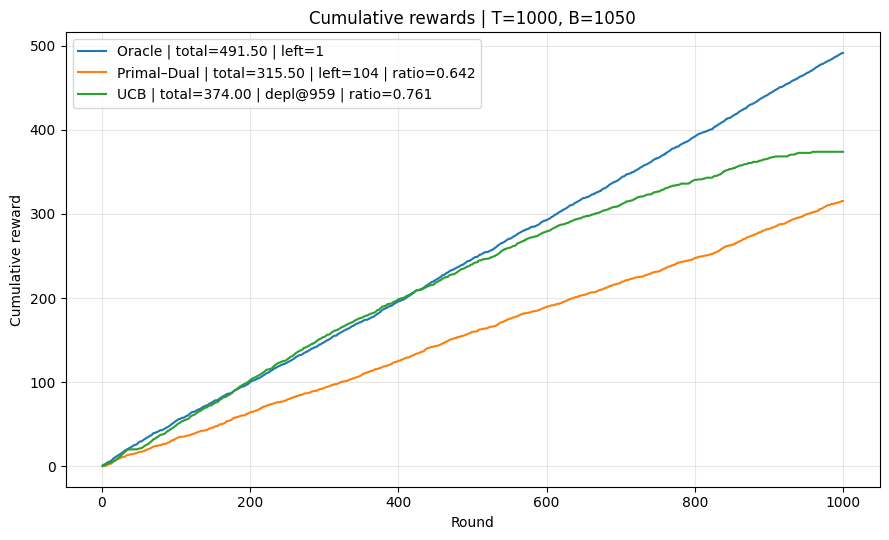

{'oracle': {'total': 491.4999999999991, 'depletion_round': None, 'leftover': 1}, 'primal_dual': {'total': 315.49999999999886, 'depletion_round': None, 'leftover': 104, 'ratio_vs_oracle': 0.6419125127161739}, 'ucb': {'total': 373.99999999999926, 'depletion_round': 959, 'leftover': 0, 'ratio_vs_oracle': 0.760935910478128}}


In [21]:
# Example config
k = 3
T = 1000
B = 1050
a_vec = [2.0, 4.0, 3.0]
b_vec = [6.0, 2.0, 5.0]
arm_values_per_product = [
    [0.2, 0.4, 0.8], # product 0 prices
    [0.2, 0.5, 0.9], # product 1 prices
    [0.1, 0.3, 0.9]  # product 2 prices
]

summary = run_agents_and_plot(
    arm_values_per_product=arm_values_per_product,
    a_vec=a_vec, b_vec=b_vec,
    T=T, B=B,
    pd_kwargs=dict(eta_mult=1.0, forget_beta=0.02, dynamic_rho=False),
    ucb_kwargs={}, oracle_kwargs={}
)

print(summary)


In [22]:
import numpy as np
from scipy.stats import beta, norm

class MultiProductCorrelatedNonStationaryEnv:
    """
    3-product, highly non-stationary environment with correlated valuations in (0,1).

    Marginals (per product m):
      - Mean mu_m(t) drifts by ±u_m with flips every K rounds, reflected at [mu_min, mu_max].
      - Beta(a_m(t), b_m(t)) with fixed concentration c => a_m = mu_m*c, b_m = (1-mu_m)*c.

    Dependence:
      - At each round t, draw Z_t ~ N(0, R_t) with a time-varying correlation matrix R_t.
      - U_t = Φ(Z_t), valuations v_m(t) = Beta^{-1}(U_m; a_m(t), b_m(t)).
      - R_t alternates between regimes (e.g., negative corr between (1,2) for a while,
        then flips), with optional interpolation to avoid hard jumps.

    API compatible with your stochastic env:
      - reset()
      - play_round() -> np.ndarray shape (3,) with entries in (0,1)
    """

    def __init__(self, T,
                 u=(0.03, 0.03, 0.03), K=25,
                 mu0=(0.25, 0.45, 0.35),
                 mu_bounds=(0.05, 0.95),
                 v_target=0.03,      # target upper bound on variance ⇒ sets concentration
                 Kc=17,              # correlation regime length (independent from K)
                 interp_frac=0.35,   # smooth interpolation between regimes
                 seed=None):
        self.k = 3
        self.T = int(T)
        self.K = int(K)
        self.Kc = int(Kc)
        self.mu_min, self.mu_max = map(float, mu_bounds)

        self.u = np.asarray(u, dtype=float).reshape(3,)
        self.mu0 = np.asarray(mu0, dtype=float).reshape(3,)
        self.mu = np.clip(self.mu0.copy(), self.mu_min, self.mu_max)

        # Fixed concentration c from target variance at mu=0.5 (like your 1D env)
        assert 0.0 < v_target < 0.25
        self.v_target = float(v_target)
        self.c = 0.25 / self.v_target - 1.0

        # Trend directions (+1/-1) per product
        rng0 = np.random.default_rng(seed)
        self.rng = rng0
        self.dir = rng0.choice([-1.0, 1.0], size=3)

        # Correlation regime design: two base matrices we’ll alternate between
        # Regime A: strong NEGATIVE corr between (1,2), mild pos with product 3
        self.R_A = np.array([
            [ 1.0, -0.85,  0.35],
            [-0.85, 1.0,  -0.10],
            [ 0.35,-0.10,  1.0]
        ], dtype=float)

        # Regime B: flip signs to emulate phases where products move together
        self.R_B = np.array([
            [ 1.0,  0.60,  0.25],
            [ 0.60, 1.0,   0.45],
            [ 0.25, 0.45,  1.0]
        ], dtype=float)

        self.interp_frac = float(np.clip(interp_frac, 0.0, 1.0))

        # Internal state
        self.current_round = 0

    # ---------- helpers ----------
    def _reflect(self, mu, direction):
        mu = mu.copy(); direction = direction.copy()
        for i in range(3):
            if mu[i] > self.mu_max:
                over = mu[i] - self.mu_max
                mu[i] = self.mu_max - over
                direction[i] *= -1
            elif mu[i] < self.mu_min:
                over = self.mu_min - mu[i]
                mu[i] = self.mu_min + over
                direction[i] *= -1
        return mu, direction

    def _corr_matrix_at_t(self, t):
        # Which regime segment are we in?
        seg = t // self.Kc
        within = (t % self.Kc) / max(1, self.Kc - 1)  # 0..1 inside segment

        base_a = self.R_A if (seg % 2 == 0) else self.R_B
        base_b = self.R_B if (seg % 2 == 0) else self.R_A

        # Smoothly nudge from base_a toward base_b within each segment (small amount)
        alpha = self.interp_frac * within  # 0..interp_frac
        R = (1 - alpha) * base_a + alpha * base_b

        # Ensure R is a valid correlation matrix: symmetrize + project
        R = 0.5 * (R + R.T)
        # Simple eigenvalue floor
        w, V = np.linalg.eigh(R)
        w = np.maximum(w, 1e-6)
        R = (V * w) @ V.T
        # Normalize to unit diagonal
        d = np.sqrt(np.clip(np.diag(R), 1e-8, None))
        R = R / np.outer(d, d)
        np.fill_diagonal(R, 1.0)
        return R

    # ---------- public API ----------
    def reset(self):
        self.current_round = 0
        self.mu = np.clip(self.mu0.copy(), self.mu_min, self.mu_max)
        # re-randomize directions to avoid locking to the same pattern after reset
        self.dir = self.rng.choice([-1.0, 1.0], size=3)

    def play_round(self):
        if self.current_round >= self.T:
            raise StopIteration("Time horizon exceeded.")

        t = self.current_round

        # Build Beta params from current means and fixed concentration
        a = np.maximum(self.mu * self.c, 1e-9)
        b = np.maximum((1.0 - self.mu) * self.c, 1e-9)

        # Time-varying correlation (Gaussian copula)
        R_t = self._corr_matrix_at_t(t)
        # Draw correlated normals
        z = self.rng.multivariate_normal(mean=np.zeros(3), cov=R_t)
        uvec = norm.cdf(z)  # Uniforms in (0,1)

        # Invert Beta CDF to get valuations with Beta(a,b) marginals
        vals = np.array([beta.ppf(uvec[i], a[i], b[i]) for i in range(3)], dtype=float)

        # Advance means for next round: flip directions every K rounds, reflect at bounds
        if (t + 1) % self.K == 0:
            self.dir *= -1.0
        mu_next = self.mu + self.dir * self.u
        self.mu, self.dir = self._reflect(mu_next, self.dir)

        self.current_round += 1
        return vals


In [23]:
import numpy as np
from scipy.optimize import linprog
from scipy.stats import beta

class MultiProductNSOracleAgent:
    """
    Oracle for multi-product, time-varying (non-stationary) marginals.
    Solves ONE LP at init to get a per-(t, m) randomized pricing policy.

    API compatible with your agents:
      - choose_superarm() -> tuple[idx or None per product]
      - update(chosen_superarm, valuation_vector) -> (reward, sales_this_round)
    """

    def __init__(self, arm_values_per_product, T, B,
                 a_path=None, b_path=None,
                 mu_path=None, concentration_c=None,
                 rng=None):
        """
        Exactly one of:
          - (a_path, b_path) of shape (T, k)
          - (mu_path, concentration_c) where a=mu*c, b=(1-mu)*c

        arm_values_per_product: list[list[float]] prices, same #arms for each product
        T: horizon
        B: total budget
        """
        self.prices = [np.asarray(v, dtype=float) for v in arm_values_per_product]
        self.k = len(self.prices)
        self.n_arms = len(self.prices[0])
        for m in range(self.k):
            assert len(self.prices[m]) == self.n_arms, "same #arms per product"

        self.T = int(T)
        self.B0 = int(B)
        self.remaining_budget = int(B)
        self.round = 0
        self.total_reward = 0.0
        self.rng = np.random.default_rng(rng)

        # ---- Build time-varying Beta parameters per (t,m) ----
        if a_path is not None and b_path is not None:
            a_path = np.asarray(a_path, dtype=float)
            b_path = np.asarray(b_path, dtype=float)
            assert a_path.shape == (self.T, self.k) and b_path.shape == (self.T, self.k)
        elif mu_path is not None and concentration_c is not None:
            mu_path = np.asarray(mu_path, dtype=float)
            assert mu_path.shape == (self.T, self.k)
            c = float(concentration_c)
            a_path = np.maximum(mu_path * c, 1e-12)
            b_path = np.maximum((1.0 - mu_path) * c, 1e-12)
        else:
            raise ValueError("Provide either (a_path,b_path) or (mu_path, concentration_c).")

        self.a_path = a_path
        self.b_path = b_path

        # ---- Precompute success probabilities and expected rewards ----
        # p_succ[t,m,a] = P(v_{t,m} >= price_{m,a})
        self.p_succ = np.zeros((self.T, self.k, self.n_arms), dtype=float)
        self.exp_rew = np.zeros((self.T, self.k, self.n_arms), dtype=float)

        for t in range(self.T):
            for m in range(self.k):
                a_t, b_t = float(a_path[t, m]), float(b_path[t, m])
                for a_idx in range(self.n_arms):
                    price = float(self.prices[m][a_idx])
                    ps = 1.0 - beta.cdf(price, a_t, b_t)
                    self.p_succ[t, m, a_idx] = ps
                    self.exp_rew[t, m, a_idx] = ps * price

        # ---- Solve single LP: variables x[t,m,a] in [0,1] ----
        # maximize sum x * exp_rew  s.t.
        #   sum x * p_succ <= B
        #   for each (t,m): sum_a x[t,m,a] <= 1
        #   0 <= x <= 1
        nvars = self.T * self.k * self.n_arms

        def idx(t, m, a_idx):
            return (t * self.k + m) * self.n_arms + a_idx

        c_vec = -self.exp_rew.reshape(-1)  # linprog minimizes

        # Budget constraint (1 row)
        A_budget = self.p_succ.reshape(1, -1)
        b_budget = np.array([self.B0], dtype=float)

        # Per-(t,m) constraints
        rows = []
        rhs = []
        for t in range(self.T):
            for m in range(self.k):
                row = np.zeros(nvars, dtype=float)
                base = (t * self.k + m) * self.n_arms
                row[base:base + self.n_arms] = 1.0
                rows.append(row)
                rhs.append(1.0)
        A_tm = np.vstack(rows)
        b_tm = np.asarray(rhs, dtype=float)

        A_ub = np.vstack([A_budget, A_tm])
        b_ub = np.concatenate([b_budget, b_tm])

        bounds = [(0.0, 1.0) for _ in range(nvars)]

        res = linprog(c_vec, A_ub=A_ub, b_ub=b_ub, bounds=bounds, method="highs")

        if not res.success:
            raise RuntimeError(f"Oracle LP failed: {res.message}")

        x = res.x.reshape(self.T, self.k, self.n_arms)

        # Store per-(t,m) policy (include skip prob)
        self.pi = np.clip(x, 0.0, 1.0)
        self.pi_skip = np.maximum(0.0, 1.0 - self.pi.sum(axis=2))  # shape (T,k)

    # ---- policy execution API ----
    def choose_superarm(self):
        if self.round >= self.T or self.remaining_budget <= 0:
            return None

        t = self.round
        choices = []
        for m in range(self.k):
            probs = np.append(self.pi[t, m], self.pi_skip[t, m])  # arms + skip
            if probs.sum() <= 0:
                # no action this product
                choices.append(None)
                continue
            probs = probs / probs.sum()
            draw = int(self.rng.choice(self.n_arms + 1, p=probs))
            if draw == self.n_arms:
                choices.append(None)  # skip
            else:
                choices.append(draw)

        return tuple(choices)

    def update(self, chosen_superarm, valuation_vector):
        if chosen_superarm is None:
            return 0.0, 0

        sales = 0
        reward = 0.0

        for m, a_idx in enumerate(chosen_superarm):
            if a_idx is None:
                continue
            price = float(self.prices[m][a_idx])
            if valuation_vector[m] >= price:
                sales += 1
                reward += price

        self.remaining_budget = max(0, self.remaining_budget - sales)
        self.total_reward += reward
        self.round += 1
        return reward, sales

    # optional helpers
    def policy_tables(self):
        """Return (pi, pi_skip) for inspection: shapes (T,k,n_arms) and (T,k)."""
        return self.pi.copy(), self.pi_skip.copy()


In [24]:
def build_beta_paths_trendflip(T, mu0, u, K, mu_bounds, v_target, seed=None):
    """
    Reconstruct time-varying Beta(a,b) paths for k products using your 1D Trend-Flip rule.
    Inputs can be scalars or length-k arrays for mu0 and u.

    Returns:
      a_path, b_path of shape (T, k)
    """
    mu0 = np.atleast_1d(np.asarray(mu0, dtype=float))
    u = np.atleast_1d(np.asarray(u, dtype=float))
    k = len(mu0)
    assert len(u) == k
    mu_min, mu_max = map(float, mu_bounds)
    assert 0.0 < v_target < 0.25
    c = 0.25 / v_target - 1.0

    rng = np.random.default_rng(seed)
    directions = rng.choice([-1.0, 1.0], size=k)

    mu = np.clip(mu0.copy(), mu_min, mu_max)
    a_path = np.zeros((T, k), dtype=float)
    b_path = np.zeros((T, k), dtype=float)

    def reflect(mu_vec, dir_vec):
        mu_new, dir_new = mu_vec.copy(), dir_vec.copy()
        for i in range(k):
            if mu_new[i] > mu_max:
                over = mu_new[i] - mu_max
                mu_new[i] = mu_max - over
                dir_new[i] *= -1
            elif mu_new[i] < mu_min:
                over = mu_min - mu_new[i]
                mu_new[i] = mu_min + over
                dir_new[i] *= -1
        return mu_new, dir_new

    for t in range(T):
        a_path[t] = np.maximum(mu * c, 1e-12)
        b_path[t] = np.maximum((1.0 - mu) * c, 1e-12)

        if (t + 1) % int(K) == 0:
            directions *= -1.0
        mu_next = mu + directions * u
        mu, directions = reflect(mu_next, directions)

    return a_path, b_path


In [25]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.optimize import linprog
from scipy.stats import beta

# Assumed available in scope:
# - MultiProductCorrelatedNonStationaryEnv  (the correlated, non-stationary env)
# - MultiProductNSOracleAgent               (the one-shot LP oracle)
# - MultiProductPrimalDualAgent             (the decomposed primal–dual agent)
# - MultiProductBudgetedUCBAgent            (your UCB)
# If not, import them from your modules.

# --- helper: rebuild time-varying Beta(a,b) paths from Trend-Flip params ---
def build_beta_paths_trendflip(T, mu0, u, K, mu_bounds, v_target, seed=None):
    """
    Reconstruct per-(t,m) Beta params using your 1D Trend-Flip rule,
    so the oracle can compute success probabilities without simulating the env.
    """
    mu0 = np.asarray(mu0, dtype=float).reshape(-1)
    u = np.asarray(u, dtype=float).reshape(-1)
    k = len(mu0)
    assert len(u) == k
    mu_min, mu_max = map(float, mu_bounds)
    assert 0.0 < v_target < 0.25
    c = 0.25 / v_target - 1.0

    rng = np.random.default_rng(seed)
    directions = rng.choice([-1.0, 1.0], size=k)
    mu = np.clip(mu0.copy(), mu_min, mu_max)

    a_path = np.zeros((T, k), dtype=float)
    b_path = np.zeros((T, k), dtype=float)

    def reflect(mu_vec, dir_vec):
        mu_new, dir_new = mu_vec.copy(), dir_vec.copy()
        for i in range(k):
            if mu_new[i] > mu_max:
                over = mu_new[i] - mu_max
                mu_new[i] = mu_max - over
                dir_new[i] *= -1
            elif mu_new[i] < mu_min:
                over = mu_min - mu_new[i]
                mu_new[i] = mu_min + over
                dir_new[i] *= -1
        return mu_new, dir_new

    for t in range(T):
        a_path[t] = np.maximum(mu * c, 1e-12)
        b_path[t] = np.maximum((1.0 - mu) * c, 1e-12)

        if (t + 1) % int(K) == 0:
            directions *= -1.0
        mu_next = mu + directions * u
        mu, directions = reflect(mu_next, directions)

    return a_path, b_path

# --- simulate a single valuation path from the correlated env ---
def _generate_ns_valuation_path(env_ctor_kwargs):
    env = MultiProductCorrelatedNonStationaryEnv(**env_ctor_kwargs)
    valuations = []
    for _ in range(env_ctor_kwargs["T"]):
        v = env.play_round()
        valuations.append(np.asarray(v, dtype=float))
    return np.vstack(valuations)  # shape (T, 3)

def _simulate_agent_on_path(valuations_Tk, agent):
    T, k = valuations_Tk.shape
    rewards = np.zeros(T, dtype=float)
    budgets = np.zeros(T, dtype=int)
    depletion_round = None

    for t in range(T):
        choice = agent.choose_superarm()
        if choice is None:
            budgets[t] = getattr(agent, "remaining_budget", 0)
            continue
        r, sold = agent.update(choice, valuations_Tk[t])
        rewards[t] = r
        budgets[t] = getattr(agent, "remaining_budget", 0)
        if depletion_round is None and budgets[t] <= 0:
            depletion_round = t + 1  # 1-based
    return rewards, budgets, depletion_round

def run_ns_env_agents_and_plot(
    arm_values_per_product,
    T, B,
    # Env params (must match your MultiProductCorrelatedNonStationaryEnv)
    mu0=(0.25, 0.45, 0.35),
    u=(0.03, 0.03, 0.03),
    K=25,
    mu_bounds=(0.05, 0.95),
    v_target=0.03,
    Kc=17,
    interp_frac=0.35,
    seed=123,
    # Agent kwargs
    pd_kwargs=None,     # kwargs for MultiProductPrimalDualAgent
    ucb_kwargs=None,    # kwargs for MultiProductBudgetedUCBAgent
    oracle_kwargs=None  # extra kwargs for MultiProductNSOracleAgent
):
    """
    Runs Oracle (one-shot policy), Primal–Dual, and UCB on the same
    correlated non-stationary valuation path. Produces the requested plot.
    """
    pd_kwargs = {} if pd_kwargs is None else dict(pd_kwargs)
    ucb_kwargs = {} if ucb_kwargs is None else dict(ucb_kwargs)
    oracle_kwargs = {} if oracle_kwargs is None else dict(oracle_kwargs)

    # --- 1) Build one path from the correlated env ---
    env_ctor_kwargs = dict(
        T=T, u=u, K=K, mu0=mu0, mu_bounds=mu_bounds, v_target=v_target,
        Kc=Kc, interp_frac=interp_frac, seed=seed
    )
    valuations_Tk = _generate_ns_valuation_path(env_ctor_kwargs)  # (T,3)

    # --- 2) Build Beta(a,b) paths for oracle (marginals only; correlation irrelevant for LP) ---
    a_path, b_path = build_beta_paths_trendflip(
        T=T, mu0=mu0, u=u, K=K, mu_bounds=mu_bounds, v_target=v_target, seed=seed
    )

    # --- 3) Instantiate agents fresh ---
    oracle = MultiProductNSOracleAgent(
        arm_values_per_product=arm_values_per_product,
        T=T, B=B,
        a_path=a_path, b_path=b_path,
        **oracle_kwargs
    )
    pd_agent = MultiProductPrimalDualAgent(
        arm_values_per_product=arm_values_per_product,
        T=T, B=B, rng=seed,
        **pd_kwargs
    )
    ucb_agent = MultiProductBudgetedUCBAgent(
        arm_values_per_product=arm_values_per_product,
        T=T, B=B,
        **ucb_kwargs
    )

    # --- 4) Simulate each agent on the same path ---
    or_rewards, or_budgets, or_depl = _simulate_agent_on_path(valuations_Tk, oracle)
    pd_rewards, pd_budgets, pd_depl = _simulate_agent_on_path(valuations_Tk, pd_agent)
    ucb_rewards, ucb_budgets, ucb_depl = _simulate_agent_on_path(valuations_Tk, ucb_agent)

    # --- 5) Plot cumulative rewards with legend details ---
    or_cum = np.cumsum(or_rewards)
    pd_cum = np.cumsum(pd_rewards)
    ucb_cum = np.cumsum(ucb_rewards)

    or_total = float(or_cum[-1])
    pd_total = float(pd_cum[-1])
    ucb_total = float(ucb_cum[-1])

    def safe_ratio(x, y):
        return (x / y) if y > 0 else np.nan

    pd_ratio = safe_ratio(pd_total, or_total)
    ucb_ratio = safe_ratio(ucb_total, or_total)

    def leftover(budgets_trace, depl_round):
        # leftover at end if not depleted
        return int(budgets_trace[-1]) if depl_round is None else 0

    pd_left = leftover(pd_budgets, pd_depl)
    ucb_left = leftover(ucb_budgets, ucb_depl)
    or_left = leftover(or_budgets, or_depl)

    x = np.arange(1, T + 1)
    plt.figure(figsize=(9, 5.5))
    plt.plot(x, or_cum, label=f"Oracle | total={or_total:.2f} | " +
                              (f"depl@{or_depl}" if or_depl is not None else f"left={or_left}"))
    plt.plot(x, pd_cum, label=f"Primal–Dual | total={pd_total:.2f} | " +
                              (f"depl@{pd_depl}" if pd_depl is not None else f"left={pd_left}") +
                              (f" | ratio={pd_ratio:.3f}" if np.isfinite(pd_ratio) else ""))
    plt.plot(x, ucb_cum, label=f"UCB | total={ucb_total:.2f} | " +
                               (f"depl@{ucb_depl}" if ucb_depl is not None else f"left={ucb_left}") +
                               (f" | ratio={ucb_ratio:.3f}" if np.isfinite(ucb_ratio) else ""))

    plt.xlabel("Round")
    plt.ylabel("Cumulative reward")
    plt.title(f"Correlated non-stationary env | T={T}, B={B}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return {
        "oracle": {"total": or_total, "depletion_round": or_depl, "leftover": or_left},
        "primal_dual": {"total": pd_total, "depletion_round": pd_depl, "leftover": pd_left, "ratio_vs_oracle": pd_ratio},
        "ucb": {"total": ucb_total, "depletion_round": ucb_depl, "leftover": ucb_left, "ratio_vs_oracle": ucb_ratio},
    }


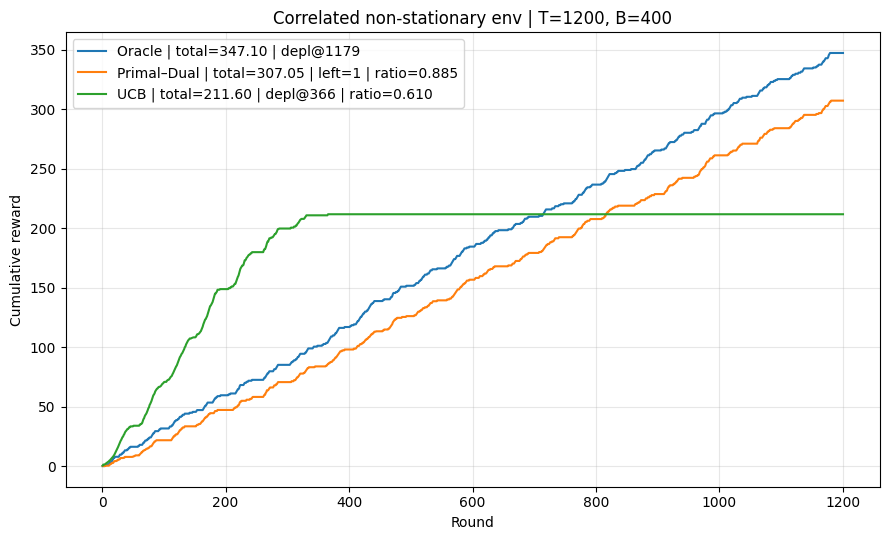

{'oracle': {'total': 347.0999999999991, 'depletion_round': 1179, 'leftover': 0}, 'primal_dual': {'total': 307.04999999999933, 'depletion_round': None, 'leftover': 1, 'ratio_vs_oracle': 0.8846153846153849}, 'ucb': {'total': 211.59999999999988, 'depletion_round': 366, 'leftover': 0, 'ratio_vs_oracle': 0.6096225871506783}}


In [26]:
# Prices per product (same #arms each)
arm_values_per_product = [
    [0.2, 0.4, 0.6, 0.8],
    [0.25, 0.5, 0.75, 0.9],
    [0.15, 0.35, 0.55, 0.7],
]

T, B = 2000, 700

summary = run_ns_env_agents_and_plot(
    arm_values_per_product=arm_values_per_product,
    T=1200, B=400,
    mu0=(0.25, 0.45, 0.35),
    u=(0.03, 0.03, 0.03),
    K=25,
    mu_bounds=(0.05, 0.95),
    v_target=0.03,
    Kc=17,
    interp_frac=0.35,
    seed=123,
    pd_kwargs=dict(
        gamma=None,           # ← your exp3p_gamma
        eta=0.2,              # ← your exp3p_eta
        dual_lr=0.01,         # ← your exp3p_dual_lr
        alpha=None,           # bias correction (leave None = canonical)
        dynamic_rho=True
    )
)

print(summary)


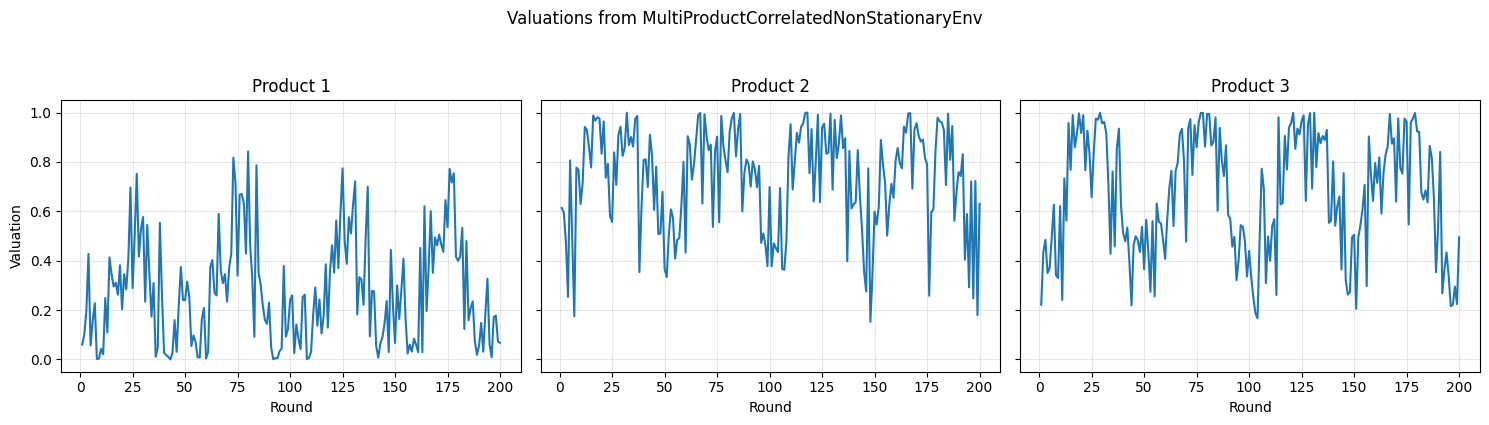

In [30]:
import matplotlib.pyplot as plt
import numpy as np

def plot_ns_env_products(env_ctor_kwargs):
    """
    Generate a single path from MultiProductCorrelatedNonStationaryEnv
    and plot the valuations of each product separately in a 1x3 grid.
    """
    env = MultiProductCorrelatedNonStationaryEnv(**env_ctor_kwargs)
    T = env_ctor_kwargs["T"]
    vals = np.zeros((T, 3))

    for t in range(T):
        vals[t] = env.play_round()

    fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharex=True, sharey=True)

    for m in range(3):
        axes[m].plot(np.arange(1, T + 1), vals[:, m], lw=1.5)
        axes[m].set_title(f"Product {m+1}")
        axes[m].set_xlabel("Round")
        if m == 0:
            axes[m].set_ylabel("Valuation")
        axes[m].grid(True, alpha=0.3)

    plt.suptitle("Valuations from MultiProductCorrelatedNonStationaryEnv", y=1.05)
    plt.tight_layout()
    plt.show()

# Example usage:
env_kwargs = dict(
    T=200,
    u=(0.03, 0.03, 0.03),
    K=25,
    mu0=(0.25, 0.45, 0.35),
    mu_bounds=(0.05, 0.95),
    v_target=0.03,
    Kc=17,
    interp_frac=0.35,
    seed=123
)
plot_ns_env_products(env_kwargs)


In [34]:
# ===== DETAILED ANALYSIS OF R4 RESULTS =====
print("=" * 60)
print("REQUIREMENT 4: BEST-OF-BOTH-WORLDS MULTI-PRODUCT")
print("=" * 60)

print(f"\n📊 EXPERIMENTAL SETUP:")
print(f"• Products: k={k}")
print(f"• Time horizon: T={T} rounds")
print(f"• Budget: B={B} units")
print(f"• Budget ratio: B/T = {B/T:.3f}")
print(f"• Environment: Correlated non-stationary")
print(f"• Environment parameters: u={env_kwargs.get('u', 'N/A')}, K={env_kwargs.get('K', 'N/A')}")

# Extract performance data from the summary
oracle_reward = summary['oracle']['total']
pd_reward = summary['primal_dual']['total']
ucb_reward = summary['ucb']['total']

print(f"\n🎯 FINAL PERFORMANCE:")
print(f"• Oracle total reward: {oracle_reward:.2f}")
print(f"• Primal-Dual total reward: {pd_reward:.2f}")
print(f"• UCB total reward: {ucb_reward:.2f}")

pd_ratio = summary['primal_dual']['ratio_vs_oracle']
ucb_ratio = summary['ucb']['ratio_vs_oracle']

print(f"• PD performance ratio (PD/Oracle): {pd_ratio:.3f}")
print(f"• UCB performance ratio (UCB/Oracle): {ucb_ratio:.3f}")
print(f"• PD achieves {pd_ratio*100:.1f}% of Oracle performance")
print(f"• UCB achieves {ucb_ratio*100:.1f}% of Oracle performance")

print(f"\n⏱️ BUDGET UTILIZATION:")
oracle_depletion = summary['oracle']['depletion_round']
pd_depletion = summary['primal_dual']['depletion_round']
ucb_depletion = summary['ucb']['depletion_round']

print(f"• Oracle budget depletion: Round {oracle_depletion if oracle_depletion else 'Never'}")
print(f"• PD budget depletion: Round {pd_depletion if pd_depletion else 'Never'}")
print(f"• UCB budget depletion: Round {ucb_depletion if ucb_depletion else 'Never'}")

oracle_leftover = summary['oracle']['leftover']
pd_leftover = summary['primal_dual']['leftover']
ucb_leftover = summary['ucb']['leftover']

oracle_used = B - oracle_leftover
pd_used = B - pd_leftover
ucb_used = B - ucb_leftover

print(f"• Oracle budget used: {oracle_used}/{B} ({oracle_used/B*100:.1f}%)")
print(f"• PD budget used: {pd_used}/{B} ({pd_used/B*100:.1f}%)")
print(f"• UCB budget used: {ucb_used}/{B} ({ucb_used/B*100:.1f}%)")

print(f"\n📈 COMPARATIVE PERFORMANCE:")
relative_performance = pd_reward / ucb_reward if ucb_reward > 0 else float('inf')
print(f"• PD vs UCB ratio: {relative_performance:.3f}")

if relative_performance > 1.1:
    advantage = "PD significantly outperforms UCB"
elif relative_performance > 1.05:
    advantage = "PD slightly outperforms UCB"
elif relative_performance > 0.95:
    advantage = "PD and UCB perform similarly"
elif relative_performance > 0.9:
    advantage = "UCB slightly outperforms PD"
else:
    advantage = "UCB significantly outperforms PD"

print(f"• Relative advantage: {advantage}")

print(f"\n🔄 NON-STATIONARITY ROBUSTNESS:")
# Budget depletion timing analysis
if oracle_depletion and ucb_depletion:
    if pd_depletion:
        depletion_order = sorted([('Oracle', oracle_depletion), ('PD', pd_depletion), ('UCB', ucb_depletion)], key=lambda x: x[1])
    else:
        depletion_order = sorted([('Oracle', oracle_depletion), ('UCB', ucb_depletion)], key=lambda x: x[1])
        depletion_order.append(('PD', 'Never'))
    
    print(f"• Budget depletion order: {' < '.join([f'{name} ({round_num})' for name, round_num in depletion_order])}")

# Performance sustainability
if pd_depletion is None:
    print(f"• PD sustained operation throughout full horizon")
else:
    print(f"• PD depleted budget at round {pd_depletion}")

if ucb_depletion and oracle_depletion:
    if ucb_depletion < oracle_depletion:
        print(f"• UCB depleted {oracle_depletion - ucb_depletion} rounds before Oracle")
    else:
        print(f"• UCB outlasted Oracle by {ucb_depletion - oracle_depletion} rounds")

print(f"\n💡 KEY INSIGHTS:")
if pd_ratio > 0.90 and ucb_ratio > 0.80:
    print("• Both algorithms demonstrate strong robustness to non-stationarity")
elif pd_ratio > 0.85 or ucb_ratio > 0.75:
    print("• Algorithms show reasonable adaptation to environmental changes")
else:
    print("• Multi-product non-stationarity poses significant challenges")

if abs(pd_ratio - ucb_ratio) < 0.05:
    print("• PD and UCB perform comparably in this setting")
elif pd_ratio > ucb_ratio:
    print("• PD's dual pacing provides advantage in multi-product coordination")
else:
    print("• UCB's direct optimization shows strength in this environment")

regret_pd = oracle_reward - pd_reward
regret_ucb = oracle_reward - ucb_reward
print(f"• PD total regret: {regret_pd:.2f} (avg: {regret_pd/T:.4f} per round)")
print(f"• UCB total regret: {regret_ucb:.2f} (avg: {regret_ucb/T:.4f} per round)")

# Budget efficiency
pd_efficiency = pd_reward / pd_used if pd_used > 0 else 0
ucb_efficiency = ucb_reward / ucb_used if ucb_used > 0 else 0
oracle_efficiency = oracle_reward / oracle_used if oracle_used > 0 else 0

print(f"• Reward per budget unit - Oracle: {oracle_efficiency:.3f}, PD: {pd_efficiency:.3f}, UCB: {ucb_efficiency:.3f}")

print("=" * 60)

REQUIREMENT 4: BEST-OF-BOTH-WORLDS MULTI-PRODUCT

📊 EXPERIMENTAL SETUP:
• Products: k=ratio_vs_oracle
• Time horizon: T=2000 rounds
• Budget: B=700 units
• Budget ratio: B/T = 0.350
• Environment: Correlated non-stationary
• Environment parameters: u=(0.03, 0.03, 0.03), K=25

🎯 FINAL PERFORMANCE:
• Oracle total reward: 347.10
• Primal-Dual total reward: 307.05
• UCB total reward: 211.60
• PD performance ratio (PD/Oracle): 0.885
• UCB performance ratio (UCB/Oracle): 0.610
• PD achieves 88.5% of Oracle performance
• UCB achieves 61.0% of Oracle performance

⏱️ BUDGET UTILIZATION:
• Oracle budget depletion: Round 1179
• PD budget depletion: Round Never
• UCB budget depletion: Round 366
• Oracle budget used: 700/700 (100.0%)
• PD budget used: 699/700 (99.9%)
• UCB budget used: 700/700 (100.0%)

📈 COMPARATIVE PERFORMANCE:
• PD vs UCB ratio: 1.451
• Relative advantage: PD significantly outperforms UCB

🔄 NON-STATIONARITY ROBUSTNESS:
• Budget depletion order: UCB (366) < Oracle (1179) < PD (N